# Abstract

Vinyl is a sequential deep learning model (recursive neural network or RNN) that classifies the genre (or genres) of a song based on its groove, where the groove is defined by the musical qualities of the notes played in a song most closely related to the rhythm and beat.

I collect data from Spotify for playlists from close to 3,000 musical genres, and obtain audio analysis data for 100-200 songs per genre. By training a specialized RNN on a sequence of each note played in each song, I build a model that is able to identify the genres most strongly represented by a song. 

Genres are not well defined at a fine level of detail, and this methodology is intended to use the vague boundaries between musical genres to produce a map or genealogy of the evolution of musical styles. This is useful for understanding the history and development of music, and for helping listeners to explore new musical styles that should be similar to their tastes.

# Obtain the Data

To build this model, I pull data from a website called [Every Noise At Once](http://everynoise.com/engenremap.html), which maps out close to 3,000 genres of music in a space that is roughly characterized by instrumentation that trends from organic to electric on the vertical axis, anda musical quality that ranges from dense and atmospheric to spiky and bouncy along the horizontal axis.

Each of these genres has its own page that contains a word cloud of popular artists in the genre, as well as links to Spotify playlists with 100-200 songs that represent the genre's style. I scrape Every Noise to collect a list of playlist URIs for each genre, and then I use the Spotify API to collect audio analysis files for the songs in each playlist.

*After completing this step, be sure to edit `references/data_dictionary` to include descriptions of where you obtained your data and what information it contains.*

In [1]:
## %%writefile ../src/data/make_dataset.py

import os, pickle, re, requests
import pandas as pd
from bs4 import BeautifulSoup


def load_or_make(filepath, creator, *args, **kwargs):
    """
    Loads data that is pickled at filepath if filepath exists;
    otherwise, calls creator(*args, **kwargs) to create the data 
    and pickle it at filepath.
    Returns the data in either case.
    
    Inputs:
    - filepath: path to where data is / should be stored
    - creator: function to create data if it is not already pickled
    - *args, **kwargs: arguments passed to creator()
    
    Outputs:
    - item: the data that is stored at filepath
    """
    if os.path.isfile(filepath):
        with open(filepath, 'rb') as pkl:
            item = pickle.load(pkl)
    else:
        item = creator(*args, **kwargs)
        with open(filepath, 'wb') as pkl:
            pickle.dump(item, pkl)
    return item


def scrape_all_links(domain, index, target_pattern):
    """
    Scrapes a website and compiles a list of urls that match a target pattern.
    
    Inputs: 
    - domain: domain of the website you want to scrape
    - index: path to the page that you want to scrape from `domain`
    - target_pattern: regex that specifies the types of links you want to collect
    
    Outputs:
    - target_urls: list of all the links on domain/index that match target_pattern
    """
    main_page = '/'.join(['http:/', domain, index])
    response = requests.get(main_page)

    if response.status_code != 200:
        raise ConnectionError(f"Failed to connect to {main_page}.")

    soup = BeautifulSoup(response.text, "lxml")

    target_regex = re.compile(target_pattern)
    target_urls = ['/'.join(['http:/', domain, x['href']])
                    for x in soup.find_all('a', {'href':target_regex})]

    return target_urls


def scrape_links_from_each_page(urls, target_pattern, labeler=(lambda x:x)):
    """
    Loops over a list of urls and finds links that matches a target pattern from each page.
    
    Inputs:
    - urls: the list of urls to scrape links from
    - target_pattern: regex that specifies the types of links you want to collect
    - labeler: function that parses a url and returns a label for that page
    
    Outputs:
    - links: a dictionary with key/value pairs {url_label:[scraped_links]}
    """
    links = {}

    for url in urls:
        response = requests.get(url)
        label = labeler(url)

        if response.status_code != 200:
            raise ConnectionError(f"Failed to connect to {url}.")

        soup = BeautifulSoup(response.text, "lxml")

        target_regex = re.compile(target_pattern)
        target_urls = [x['href'] for x in soup.find_all('a', {'href':target_regex})]

        links[label] = target_urls
    
    return links

## I DON'T KNOW HOW TO AUTHENTICATE A SPOTIFY CLIENT FROM WITHIN A JUPYTER NOTEBOOK!
## I'LL HAVE TO DO THE NEXT PARTS FROM THE COMMAND LINE.

# NOT YET IMPLEMENTED
def download_playlist_metadata(playlists, spotify_client, data_dir):
    """
    Downloads metadata of all songs from each Spotify playlist in playlist_urls,
    and saves them in DataFrames in data_dir.
    
    Inputs:
    - playlists: a dictionary with k/v pairs {playlist_name:playlist_url}
    - spotify_client: a Spotify API client created and authenticated using spotipy
    - data_dir: the directory where metadata DataFrames are to be stored
    
    Outputs:
    - none, but DataFrames are written as TSV files in data_dir
    """
    pass


# NOT YET IMPLEMENTED
def download_audio_analysis_files(playlist_df, spotify_client, data_dir):
    """
    Downloads Spotify audio analysis files for all songs in a Spotify playlist
    and pickles them in the data_dir directory. Note that the Spotify client
    must be created and authenticated in the environment outside of this script.

    TODO: find out how to programmatically authenticate a Spotify client object.
    
    Inputs:
    - playlist_df: a DataFrame containing metadata from songs of a Spotify playlist
    - spotify_client: a Spotify API client created and authenticated using spotipy
    - data_dir: the directory where audio analysis data is to be stored
    
    Outputs:
    - none, but audio analysis files are downloaded and pickled in data_dir
    """
    pass

        
def run():
    """
    - scrape genre page urls from everynoise.com/engenremap.html,
        save as a list in ../data/raw/everynoise_genre_urls.pkl
        
    - scrape genre playlist urls from each genre page on everynoise.com,
        save as a dictionary in ../data/raw/thesoundsofspotify_playlist_urls.pkl
        
    - download playlist metadata for each playlist from Spotify,
        save as TSV files in ../data/raw/thesoundsofspotify/[genre].tsv
        
    - download audio_analysis files for each song in a list of playlists
        (not necessarily all playlists because there are 100s of 1000s in the full set)
        save as audio_analysis dictionaries in ../data/raw/audio_analysis/[song_uri].pkl
    
    TODO: include a progress indicator
    """
    genre_urls = load_or_make(
        '../data/raw/everynoise_genre_urls.pkl',
        scrape_all_links, 
        domain='everynoise.com', 
        index='engenremap.html', 
        target_pattern='engenremap-[a-z]*')
    
    genre_playlists = load_or_make(
        '../data/raw/thesoundsofspotify_playlist_urls.pkl',
        scrape_links_from_each_page,
        urls=genre_urls,
        labeler=(lambda url: url.split('/')[-1].split('-')[-1].split('.')[0]),
        target_pattern='open.spotify.com')


run()

In [2]:
## %%writefile ../src/data/spotify_metadata.py

## RUN THIS CODE IN AN IPYTHON SESSION WITH AN AUTHENTICATED SPOTIFY CLIENT
## TODO: FIGURE OUT HOW TO AUTHENTICATE FROM INSIDE A RUNNING PYTHON PROGRAM
## WITHOUT HAVING TO COPY/PASTE URI FROM BROWSER INTO PROMPT


def parse_track_tags(track):
    '''
    Parse metadata for a spotify track, return as a dict
    From a user_playlist json file, a track can be found via:
        user_playlist['tracks']['items'][i]
    '''
    return {
        'id': track['id'],
        'album': track['album']['name'],
        'track': track['track_number'],
        'title': track['name'],
        'artist': track['artists'][0]['name'],
        'duration': int(track['duration_ms']/1000),
        'preview_mp3': track['preview_url'],
        'is_explicit': track['explicit'],
        'isrc_number': track['external_ids']['isrc'],
        'release_date': track['album']['release_date'],
        'cover_art_url': track['album']['images'][0]['url']
    }


def get_playlist_metadata(tracks, client):
    """
    Downloads metadata for each track in tracks, using Spotify API client.
    Downloads audio features for each track and appends to metadata df.
    
    Inputs:
    - tracks: Spotify tracks node from playlist json data
    - client: Spotify API client
    
    Outputs:
    - metadata_df: a DataFrame merged from playlist metadata and 
        audio features downloaded for each song in the playlist
    """
    metadata = [parse_track_tags(item['track']) for item in tracks['items']]
    metadata_df = pd.DataFrame(metadata)
    song_ids = list(metadata_df['id'])
    features_df = pd.DataFrame(client.audio_features(song_ids))
    metadata_df = pd.merge(metadata_df, features_df)

    return metadata_df


def download_tracks_analysis(metadata, client):
    """
    Download audio analysis files for all tracks in playlist, using Spotify API client.
    """
    for index, row in metadata.iterrows():
        filepath = f'data/raw/audio_analysis/{row.id}.pkl'
        if not os.path.isfile(filepath):
            analysis = client.audio_analysis(row.id)
            with open(filepath, 'wb') as pkl:
                pickle.dump(analysis, pkl)


def get_sos_playlist_id(genre_playlists, genre):
    """
    Parses out the Spotify uri of a genre's playlist created by The Sounds Of Spotify,
    from a list of urls on that genre's subpage on Every Noise At Once.
    
    Inputs:
    - genre_playlists: a dict of format {genre:[playlist_urls]} for every genre on EveryNoise
    - genre: a string, genre name as it appears on EveryNoise (lowercase, hypen-joined)
    
    Outputs:
    - playlist_id: a Spotify uri to that playlist
    """
    sos_playlist = [x for x in genre_playlists[genre] if 'thesoundsofspotify' in x][0]
    return sos_playlist.split('/')[-1]


def run_playlist_metadata_pipeline(genre, genre_playlists, spotipy_client):
    """
    This is a pipeline to
        get the playlist id for a genre name,
        download playlist tracks,
        download and save playlist metadata,
        download and save tracks audio analysis        
    """
    playlist_id = get_sos_playlist_id(genre_playlists, genre)
    tracks = spotipy_client.user_playlist('thesoundsofspotify', playlist_id, fields="tracks,next")['tracks']
    with open(f'data/raw/playlist_json/{genre}.pkl', 'wb') as pkl:
        pickle.dump(tracks, pkl)
    metadata = get_playlist_metadata(tracks, spotipy_client)
    metadata.to_csv(f'data/interim/{genre}_metadata.tsv', sep='\t')
    download_tracks_analysis(metadata, spotipy_client)

#run_playlist_metadata_pipeline('techno', genre_playlists, spotipy_client)
#run_playlist_metadata_pipeline('opera', genre_playlists, spotipy_client)




In [4]:
genre = "techno"
genre_tracks = load_or_make(
    f'data/raw/playlist_json/{genre}.pkl',
    download_user_playlist_tracks,
    client = spotipy_client,
    user = 'thesoundsofspotify', 
    playlist_id = pl_id)


NameError: name 'download_user_playlist_tracks' is not defined

### Data Dictionary
```
data/
|-raw/everynoise_genre_urls.pkl
| |  /thesoundsofspotify_playlist_urls.pkl
| |--/audio_analysis/{uri}.pkl
| `--/playlist_json/{genre}.pkl
`-interim/{genre}_metadata.tsv

TODO: Write a function that walks the data directory tree and prints this output.
```

Descriptions:
- **everynoise_genre_urls.pkl**: `list` of urls for all genre subpages on everynoise.com
- **thesoundsofspotify_playlist_urls.pkl**: `dict` of genre:urls for all EveryNoise genres; urls point to Spotify playlists by users "The Sounds of Spotify" and "Particle Detector". TSOS playlists are curated lists of songs that exemplify a genre. PD playlists track most-listened to songs of fans of that genre. TSOS is more useful for genre classification because PD playlists are likely to pick up songs in related genres, not the ones we are predicting. (Still useful, but for a different problem.)
- **{uri}.pkl**: `dict` of Audio Analysis JSON file downloaded from Spotify for song {uri}
- **{genre}.pkl**: `dict` of a playlist JSON data file downloaded from Spotify
- **{genre}\_metadata.tsv**: `DataFrame` compiled from track metadata parsed from playlist JSON, merged with a DataFrame of Audio Features data downloaded from Spotify.

# Scrub the Data

So far I have:
- a directory full of `genre_metadata` DataFrames, the id of which maps to the filenames in...
- a directory full of pickled audio_analysis files for songs in each of the genre playlists.

I want to create a DataFrame of cleaned audio analysis data for each song. Eventually it may be interesting to add the Spotify Audio Features as an additional vector of features in the final layer of my neural network. But for now I will stick to the audio analysis data.

*The end goal of this step is to produce a [design matrix](https://en.wikipedia.org/wiki/Design_matrix), containing one column for every variable that you are modeling, including a column for the outputs, and one row for every observation in your data set. It needs to be in a format that won't cause any problems as you visualize and model your data.*

In [8]:
import numpy as np

def parse_groove_from_audio_analysis(analysis):
    bars = pd.DataFrame(analysis['bars'])
    segments = pd.DataFrame(analysis['segments'])

    bars['bar'] = bars.index + 1
    segments.head()
    segments['amplitude'] = segments.loudness_max - segments.loudness_start
    segments['transient'] = segments.start + segments.loudness_max_time
    segments['attack'] = segments.loudness_max_time

    notes = segments[['transient', 'amplitude', 'duration', 'attack']]

    groove = pd.merge_asof(notes, bars, left_on='transient', right_on='start')
    groove.rename(index=str, columns={"duration_x": "duration"}, inplace=True)
    groove = groove.dropna().drop('confidence', axis=1).reset_index(drop=True)
    groove['beat'] = (groove.transient - groove.start) / groove.duration_y
    groove.beat = round(groove.beat, 2)
    groove = groove[groove.beat <= 1]

    all_beats = pd.Series(np.linspace(0,0.99,100))
    missing_beats = all_beats[~all_beats.isin(groove.beat)]

    fill_groove = pd.DataFrame(np.zeros([missing_beats.shape[0], groove.shape[1]]),
                               columns=groove.columns,
                               index=missing_beats.index)

    # shouldn't have to round this, but sometimes floating point errors creep in
    fill_groove["beat"] = round(missing_beats, 2)
    
    #groove = pd.concat([groove, fill_groove])
    groove.reset_index()
    groove = groove.pivot_table(index='start', columns='beat', 
                                values=['amplitude', 'attack', 'duration'])

    groove.fillna(0, inplace=True)
    
    groove = pd.DataFrame(groove.to_records())
    groove.columns = [col.replace("('", "").replace("', ", "_").replace(")", "") for col in groove.columns]
    
    return groove

In [9]:
# data processing pipeline
# get names of all genres with a metadata tsv file in data/interim
# 

def get_genres_with_metadata(metadata_dir='../data/interim'):

    metadata_paths = [x for x in os.listdir(metadata_dir) if x.endswith('_metadata.tsv')]
    genre_ids = {x.split('_metadata')[0] : 
                 pd.read_csv(os.path.join(metadata_dir, x), sep='\t').id
                 for x in metadata_paths}
    return genre_ids


def process_grooves_from_audio_analysis(audio_analysis_dir='../data/raw/audio_analysis', 
                                        features_dir='../data/processed'):
    for genre in genre_ids.keys():
        for i in genre_ids[genre]:
            audio_analysis_path = os.path.join(audio_analysis_dir, i + '.pkl')
            groove_filepath = '_'.join([genre, i]) + '.tsv'
            if os.path.isfile(groove_filepath):
                continue

            with open(audio_analysis_path, 'rb') as pkl:
                audio_analysis = pickle.load(pkl)
            groove = parse_groove_from_audio_analysis(audio_analysis)
            groove.to_csv(os.path.join(features_dir, groove_filepath), sep='\t')

#os.listdir('../data/raw/audio_analysis')

def concatenate_supergroove_dataframe(features_dir):
    grooves = []
    for groove_tsv in os.listdir(features_dir):
        if not groove_tsv.endswith('.tsv'):
            print(f"{groove_tsv} is not a tsv file")
            continue
        groove_path = os.path.join(features_dir, groove_tsv)
        groove = pd.read_csv(groove_path, sep="\t", index_col=0)
        #if not set(list(groove.columns)) == set(cols):
        #    print(f'{groove_tsv} is not a proper groove DataFrame')
        #    continue
        genre, song_id = groove_tsv.split('_')
        song_id = song_id.split('.')[0]
        groove['genre'] = genre
        groove['song_id'] = song_id
        grooves.append(groove)
    return pd.concat(grooves)
    

In [15]:
data.to_csv("../data/processed/operatechno.tsv", sep="\t")

In [ ]:
data.head()

In [ ]:
## %%writefile ../src/features/build_features.py

import os
import pickle
import numpy as np
import pandas as pd
# helper functions go here

def run():
    """
    Executes a set of helper functions that read files from data/raw, cleans them,
    and converts the data into a design matrix that is ready for modeling.
    """
    # clean_dataset_1('data/raw', filename)
    # clean_dataset_2('data/raw', filename)
    # save_cleaned_data_1('data/interim', filename)
    # save_cleaned_data_2('data/interim', filename)
    # build_features()
    # save_features('data/processed')
    pass

## We're not quite there yet

Need to decide how to encode the timing data, and whether to include sections. (Do bar counts restart with new sections?)

Also I should detect the key of the song and cycle the pitches so that pitch_00 is tonic.

Base case SVM model: 
- loudness_delta = loundess_max - loudness_start
- fill in missing tatums with zeroes for loudness_delta, pitches, timbres, duration, attack(?)
- missing tatum time = (previous tatum time) + ((previous matching tatum count) - 1) duration
- observation = delta, attack, duration, pitches, timbres for all of the tatums in one bar
- target = genre of that bar

*Before moving on to exploratory analysis, write down some notes about challenges encountered while working with this data that might be helpful for anyone else (including yourself) who may work through this later on.*

# Explore the Data

*Before you start exploring the data, write out your thought process about what you're looking for and what you expect to find. Take a minute to confirm that your plan actually makes sense.*

*Calculate summary statistics and plot some charts to give you an idea what types of useful relationships might be in your dataset. Use these insights to go back and download additional data or engineer new features if necessary. Not now though... remember we're still just trying to finish the MVP!*

In [ ]:
import matplotlib.pyplot as plt

KeyboardInterrupt: 

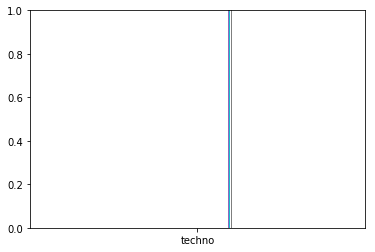

In [68]:
plt.hist(data.genre)

In [ ]:
## %%writefile ../src/visualization/visualize.py

# imports
# helper functions go here

def run():
    """
    Executes a set of helper functions that read files from data/processed,
    calculates descriptive statistics for the population, and plots charts
    that visualize interesting relationships between features.
    """
    # data = load_features('data/processed')
    # describe_features(data, 'reports/')
    # generate_charts(data, 'reports/figures/')
    pass


*What did you learn? What relationships do you think will be most helpful as you build your model?*

# Model the Data

*Describe the algorithm or algorithms that you plan to use to train with your data. How do these algorithms work? Why are they good choices for this data and problem space?*

In [49]:
def songid_partition(groove_df, test_size=0.2):
    ids = groove_df.song_id.unique()
    nids = ids.shape[0]
    a = np.zeros(nids, dtype=int)
    ntest = int(nids * test_size)
    a[:ntest] = 1
    np.random.shuffle(a)
    a = a.astype(bool)
    train_ids = ~a
    return ids[train_ids], ids[a]

def groove_train_test_split(groove_df, target_genre, test_size=0.2):
    train_ids, test_ids = songid_partition(groove_df, test_size)
    train_set = groove_df[groove_df.song_id.isin(train_ids)]
    X_train = train_set.drop(['genre', 'song_id', 'start'], axis=1)
    y_train = np.zeros_like(train_set['genre']).astype('int')
    y_train[train_set.genre == target_genre] = 1
    test_set = groove_df[groove_df.song_id.isin(test_ids)]
    X_test = test_set.drop(['genre', 'song_id', 'start'], axis=1)
    y_test = np.zeros_like(test_set['genre']).astype('int')
    y_test[test_set.genre == target_genre] = 1
    return X_train, X_test, y_train, y_test

In [50]:
X_train, X_test, y_train, y_test = groove_train_test_split(data.dropna(), 'techno')

In [51]:
from sklearn.decomposition import PCA
pca = PCA(n_components=50)
pca.fit(X_train)
pcafeatures_train = pca.transform(X_train)
pcafeatures_test = pca.transform(X_test)

In [52]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

lr = LogisticRegression(solver='lbfgs')
lr.fit(pcafeatures_train, y_train)
f1_score(lr.predict(pcafeatures_test), y_test)

/Users/cliffclive/anaconda3/envs/metis/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.0

In [64]:
np.histogram(y_train)

(array([12157,     0,     0,     0,     0,     0,     0,     0,     0,
          431]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]))

In [ ]:
## %%writefile ../src/models/train_model.py

# imports
# helper functions go here

def run():
    """
    Executes a set of helper functions that read files from data/processed,
    calculates descriptive statistics for the population, and plots charts
    that visualize interesting relationships between features.
    """
    # data = load_features('data/processed/')
    # train, test = train_test_split(data)
    # save_train_test(train, test, 'data/processed/')
    # model = build_model()
    # model.fit(train)
    # save_model(model, 'models/')
    pass


In [ ]:
## %%writefile ../src/models/predict_model.py

# imports
# helper functions go here

def run():
    """
    Executes a set of helper functions that read files from data/processed,
    calculates descriptive statistics for the population, and plots charts
    that visualize interesting relationships between features.
    """
    # test_X, test_y = load_test_data('data/processed')
    # trained_model = load_model('models/')
    # predictions = trained_model.predict(test_X)
    # metrics = evaluate(test_y, predictions)
    # save_metrics('reports/')
    pass



_Write down any thoughts you may have about working with these algorithms on this data. What other ideas do you want to try out as you iterate on this pipeline?_

# Interpret the Model

_Write up the things you learned, and how well your model performed. Be sure address the model's strengths and weaknesses. What types of data does it handle well? What types of observations tend to give it a hard time? What future work would you or someone reading this might want to do, building on the lessons learned and tools developed in this project?_